# FPCA Clustering

In [1]:
import pandas as pd
import os
import glob
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from skfda.representation.grid import FDataGrid


import skfda
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import (
    BSplineBasis,
    FourierBasis,
    MonomialBasis,
)


from __future__ import annotations

from typing import Any, Mapping, Tuple

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
from cartopy.io.img_tiles import GoogleTiles
from matplotlib.axes import Axes
from matplotlib.figure import Figure

from skfda.datasets import fetch_aemet
from skfda.exploratory.depth import ModifiedBandDepth
from skfda.exploratory.visualization import Boxplot, MagnitudeShapePlot
from skfda.exploratory.visualization.fpca import FPCAPlot
from skfda.misc.metrics import l2_distance
from skfda.ml.clustering import KMeans
from skfda.preprocessing.dim_reduction import FPCA

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Load Data for One Subject, One Frequency

In [2]:
#read each csv file in current_directory and store it in dataframes

current_directory = os.getcwd()
csv_files = glob.glob(os.path.join(current_directory, 'ABR_exported_files/*.csv'))

dataframes = {}
for file in csv_files:
    filename = os.path.splitext(os.path.basename(file))[0]
    if pd.read_csv(file).shape[1] > 1:
        dataframes[filename] = pd.read_csv(file)
    else:
        dataframes[filename] = pd.read_csv(file, skiprows=2)

In [3]:
# SELECT SUBJECT AND FREQUENCY #

######################
subject = 0
frequency = 16000
######################
waves = []
filename = list(dataframes.items())[subject][0]
df = list(dataframes.values())[subject]

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            waves.append(final.tolist())
waves = [wave[:-1] for wave in waves]

# PLOT WAVES

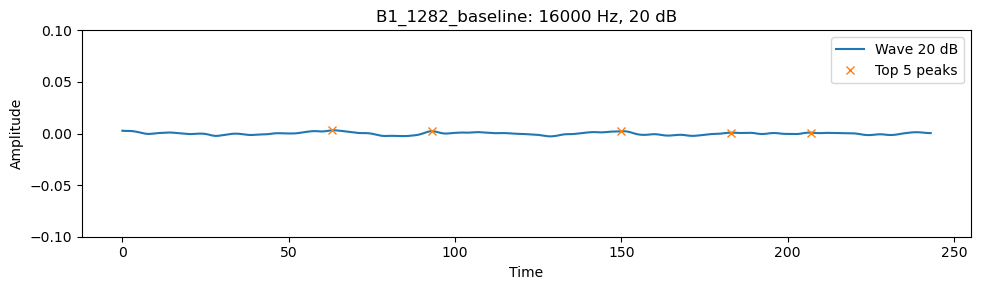

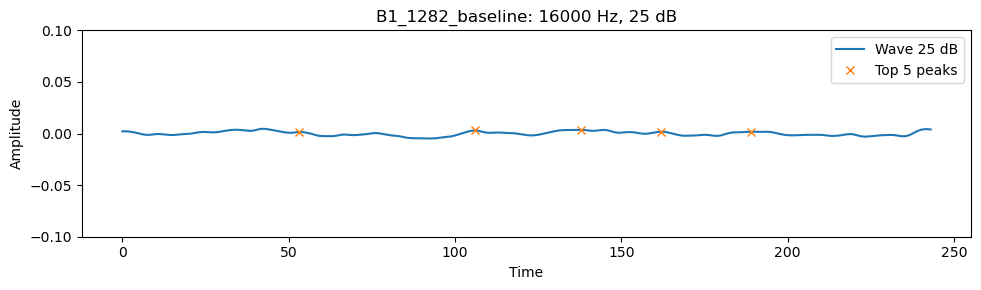

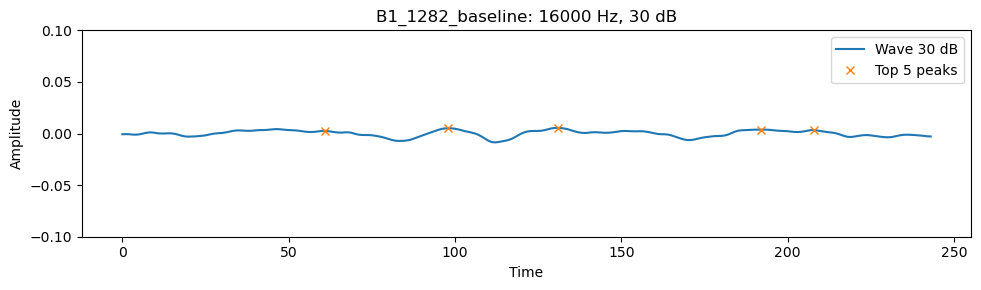

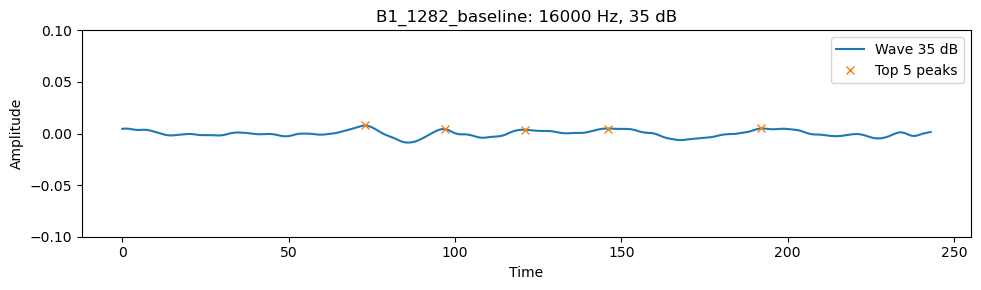

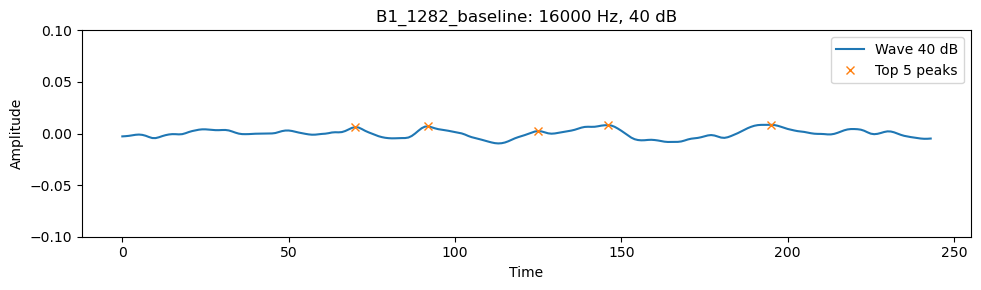

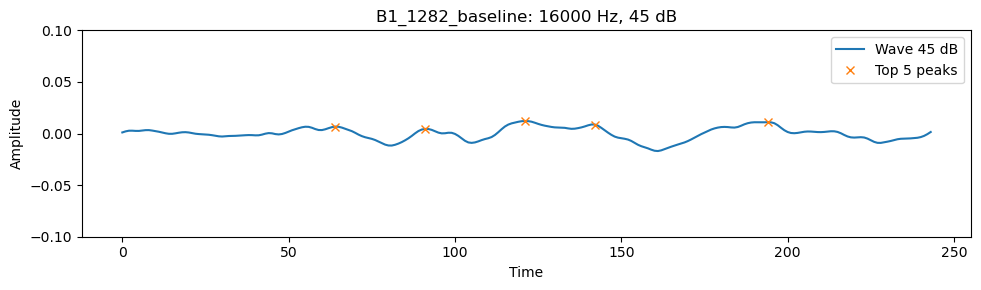

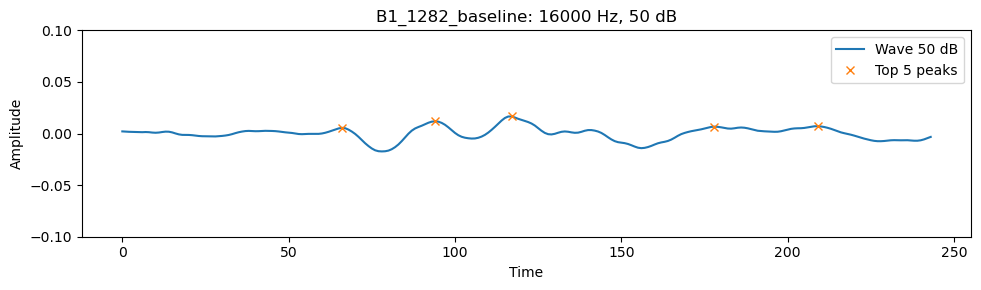

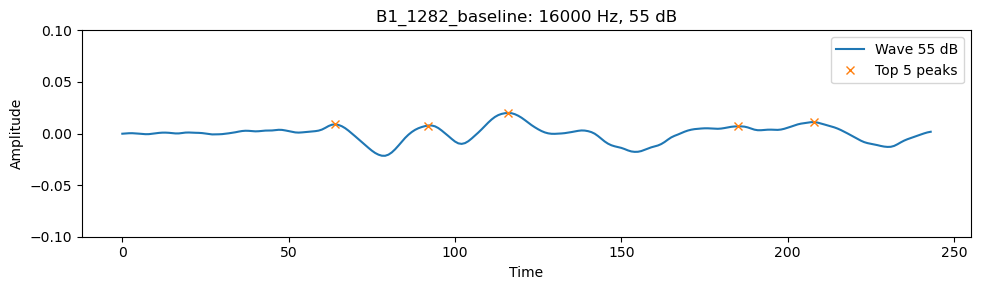

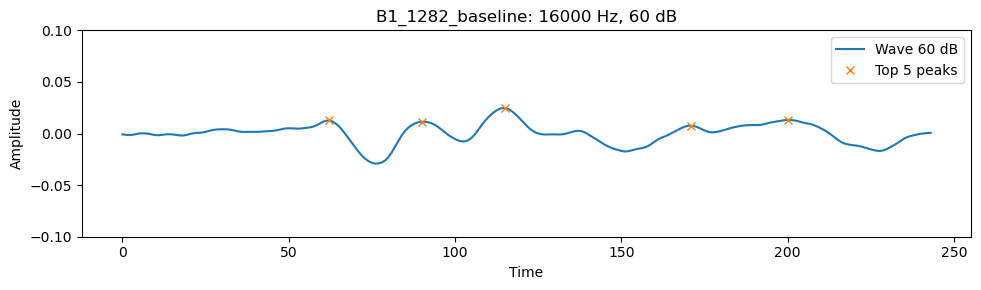

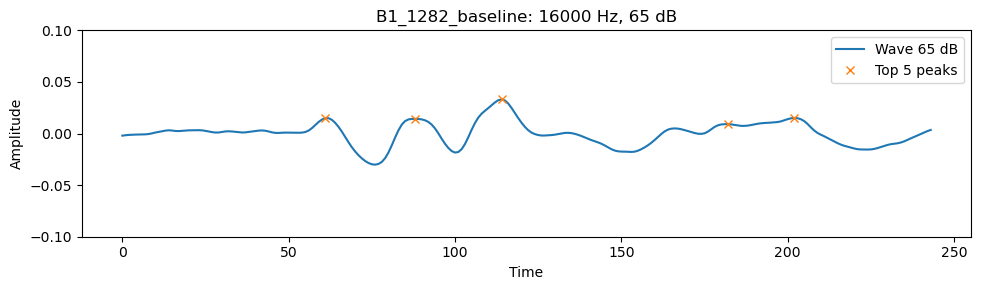

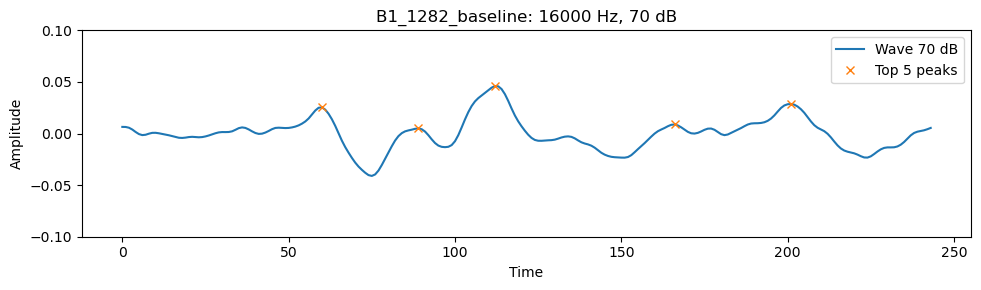

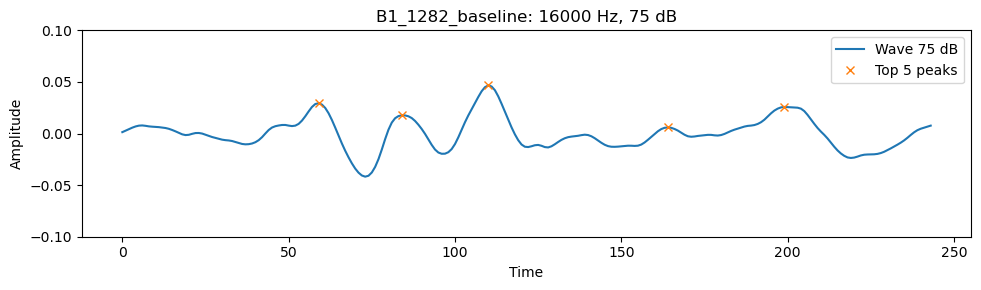

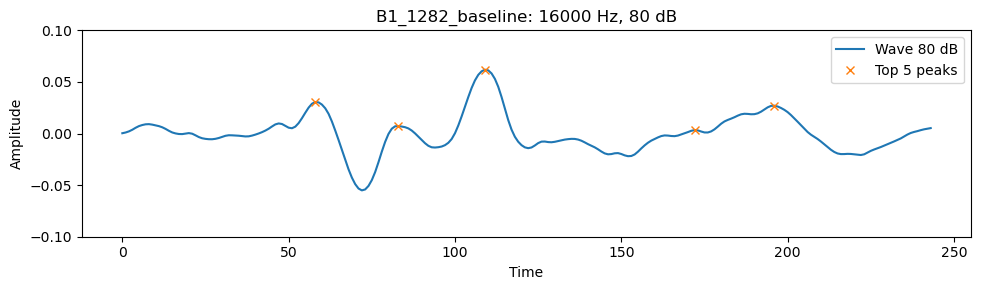

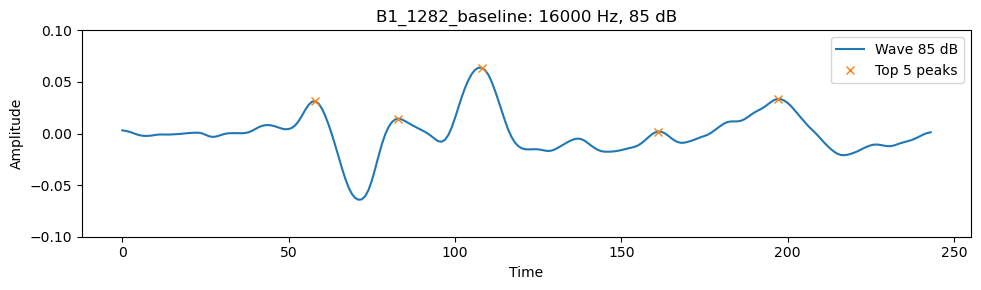

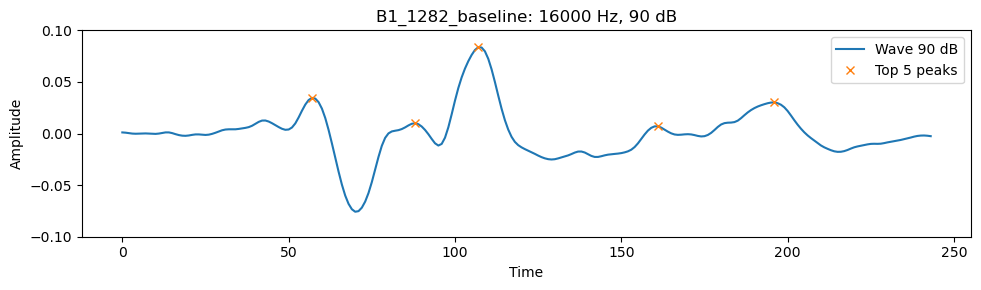

In [4]:
peaks_list = []
db_values = []
freq_values = []

for khz_value in [frequency]:
    for dbkhz_value in range(0, 95, 5):
        khz = df[df['Freq(Hz)'] == khz_value]
        dbkhz = khz[khz['Level(dB)'] == dbkhz_value]
        if not dbkhz.empty:
            index = dbkhz.index.values[0]
            final = df.iloc[index,48:]
            final = pd.to_numeric(final, errors='coerce')
            wave = final.tolist()[:-1]
            wave_after_30 = wave[50:-30]  # start from the 30th point and end before the last 30 points
            peaks, _ = find_peaks(wave_after_30, distance=15)
            peaks = [peak + 50 for peak in peaks]  # adjust the indices
            highest_peaks_indices = sorted(peaks, key=lambda x: wave[x], reverse=True)[:5]
            highest_peaks_indices.sort()
            peak_coordinates = []
            for peak in highest_peaks_indices:
                peak_coordinates.extend([peak, wave[peak]])
            peaks_list.append(peak_coordinates)
            db_values.append(dbkhz_value)
            freq_values.append(khz_value)
            fig, axs = plt.subplots(figsize=(10, 3))
            axs.plot(wave, label=f'Wave {dbkhz_value} dB')
            axs.plot(highest_peaks_indices, [wave[j] for j in highest_peaks_indices], "x", label='Top 5 peaks')
            axs.set_title(f'{filename}: {frequency} Hz, {dbkhz_value} dB')
            axs.set_xlabel('Time')
            axs.set_ylabel('Amplitude')
            axs.set_ylim(-.1,.1)
            axs.legend()
            plt.tight_layout()
            plt.show()

# Aligned Waves

Initializing...
Compute Karcher Mean of 15 function in SRSF space with lam=0
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


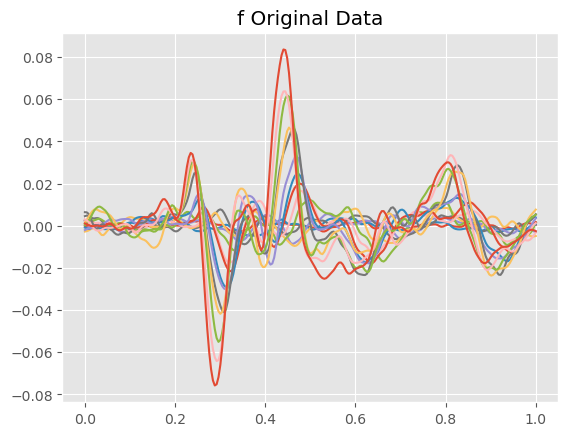

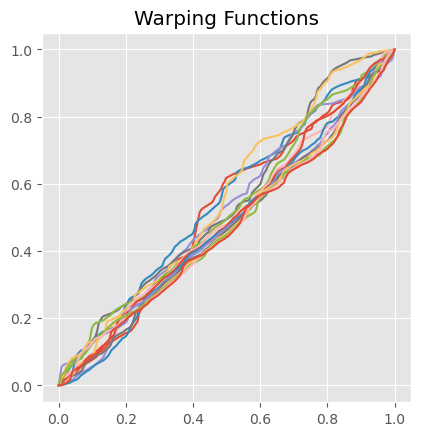

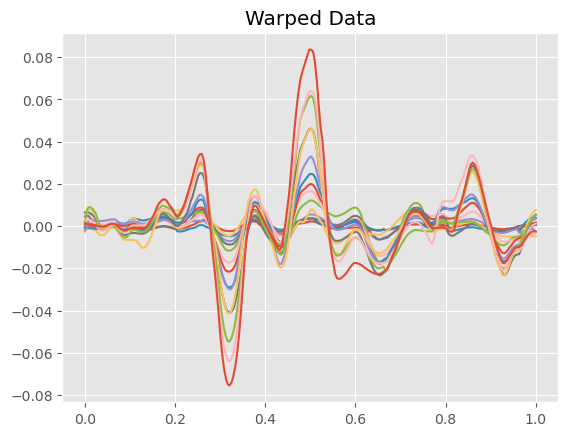

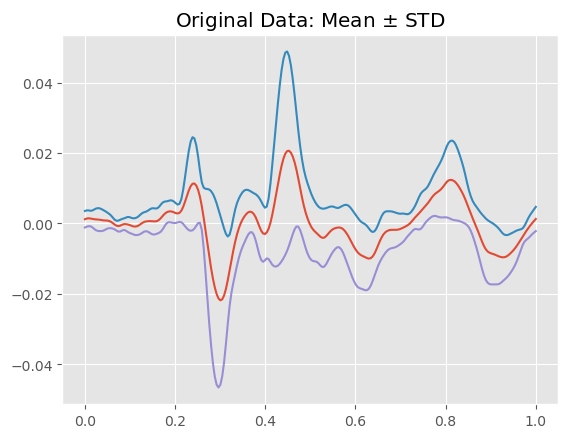

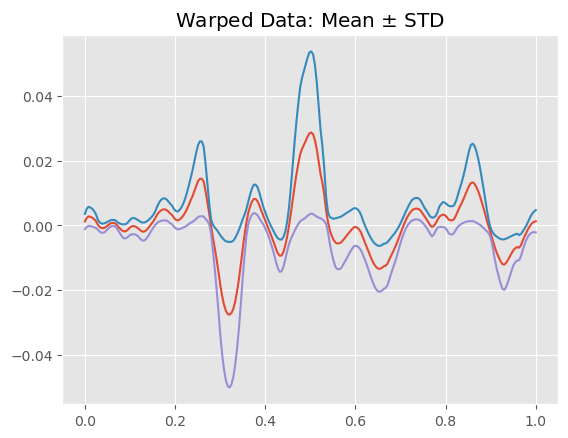

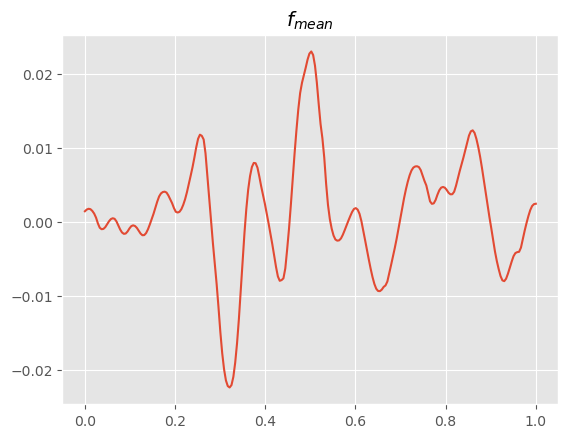

In [6]:
import fdasrsf as fs
np_waves = np.array(waves)
#time = np.linspace(0, 1, np_waves.shape[1])
time = np.arange(0,np_waves.shape[1])
obj = fs.fdawarp(np_waves.T, time)
obj.srsf_align(parallel=True)
obj.plot()

In [6]:
aligned = obj.fn.T

In [7]:
aligned

array([[ 2.69900000e-03,  2.67417398e-03,  2.64734936e-03, ...,
         1.12647156e-03,  9.41092803e-04,  4.27000000e-04],
       [ 2.10500000e-03,  2.14807164e-03,  2.19461075e-03, ...,
         4.02624026e-03,  4.09449329e-03,  3.92400000e-03],
       [-7.07000000e-04, -5.80477054e-04, -5.91139829e-04, ...,
        -1.16798900e-03, -1.72778944e-03, -2.85200000e-03],
       ...,
       [ 2.91000000e-04,  7.42474058e-03,  8.98305840e-03, ...,
         3.43666500e-03,  4.48280033e-03,  5.25100000e-03],
       [ 3.04900000e-03,  2.96070314e-03,  2.86529796e-03, ...,
         8.27963928e-05,  7.42165677e-04,  1.20400000e-03],
       [ 1.07000000e-03,  1.02441585e-03,  9.75161955e-04, ...,
        -2.59044278e-03, -2.42047472e-03, -2.55700000e-03]])

/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_50326/2551279945.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


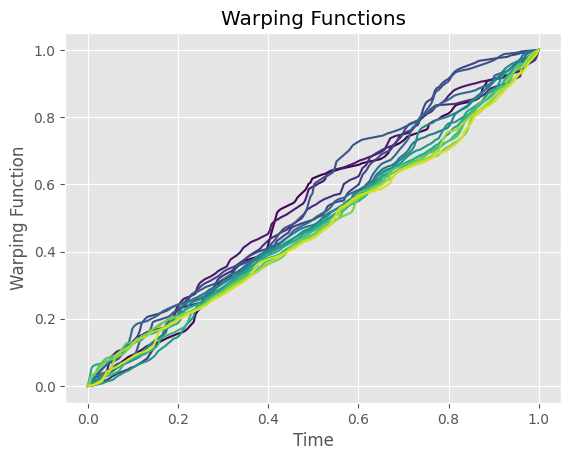

In [113]:
import matplotlib.cm as cm
#gradient warping functions

cmap = cm.get_cmap('viridis')
num_funcs = obj.gam.shape[1]
for i in range(num_funcs):
    plt.plot(time, obj.gam[:, i], color=cmap(i / num_funcs))

plt.title('Warping Functions')
plt.xlabel('Time')
plt.ylabel('Warping Function')
plt.show()


/var/folders/g_/b1twxg5159dc5n5_hm9nxdgm0000gn/T/ipykernel_50326/2584288647.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is one of the built-in colormaps


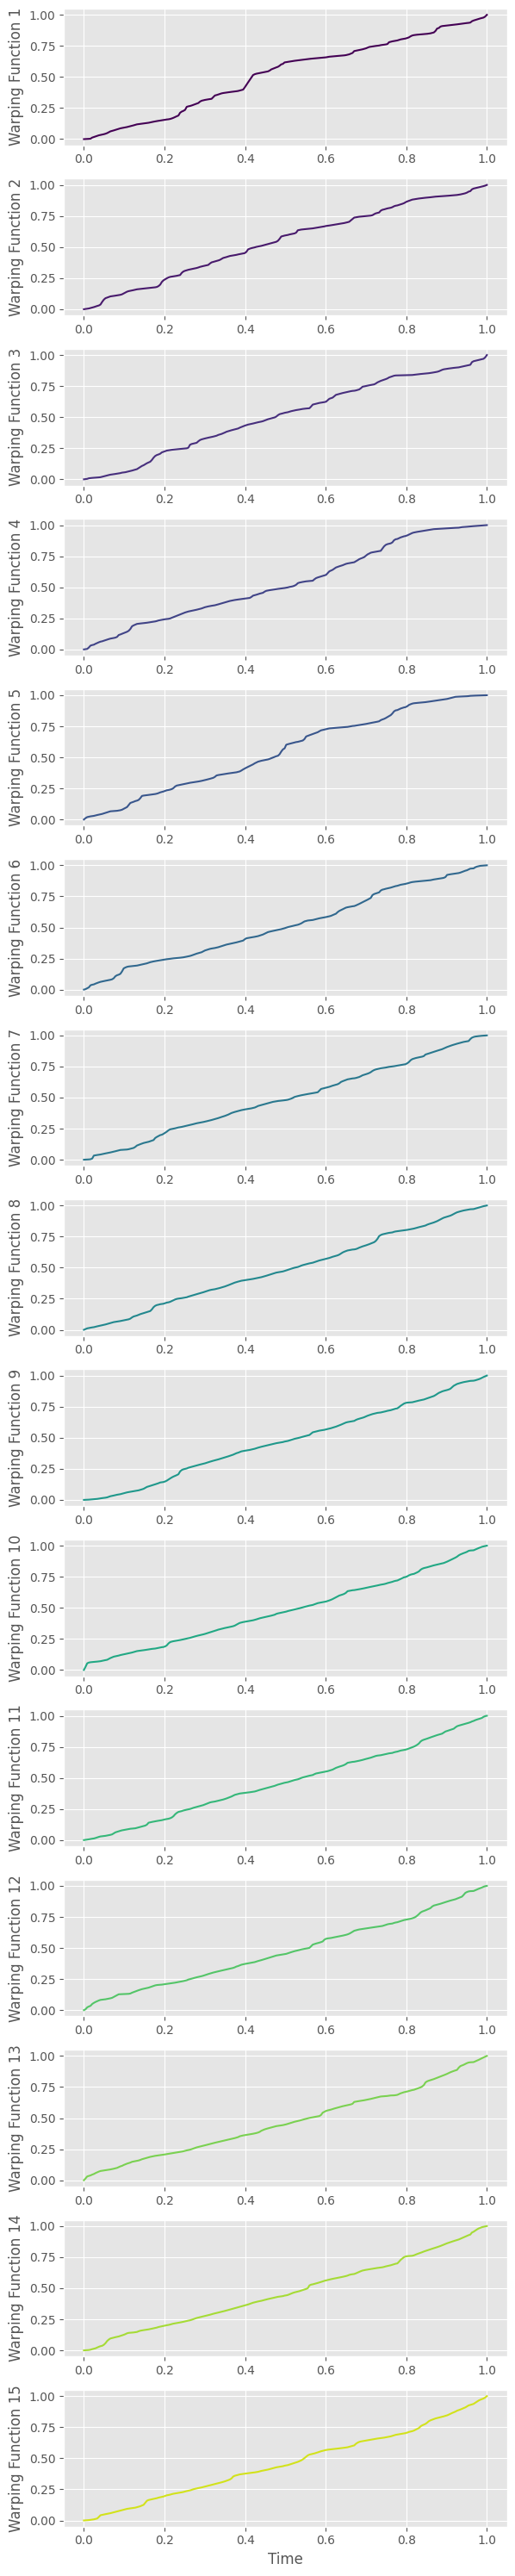

In [114]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# Create a colormap
cmap = cm.get_cmap('viridis')  # 'viridis' is one of the built-in colormaps

# Calculate the number of functions
num_funcs = obj.gam.shape[1]

# Create a normalize object that scales data to the range [0, num_funcs]
norm = Normalize(vmin=0, vmax=num_funcs)

# Create a figure
fig = plt.figure(figsize=(6, num_funcs*2))  # Adjust the size as needed

# Plot each warping function in a separate subplot
for i in range(num_funcs):
    ax = fig.add_subplot(num_funcs, 1, i+1)
    ax.plot(time, obj.gam[:, i], color=cmap(norm(i)))
    ax.set_ylabel('Warping Function {}'.format(i+1))

plt.xlabel('Time')
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()


# FPCA

In [7]:
aligned = obj.fn.T

In [9]:
len(aligned[0])

244

In [116]:
waves_fd = FDataGrid(aligned)
fpca_discretized = FPCA(n_components=3)
fpca_discretized.fit(waves_fd)

FPCA(_weights=array([0.00137174, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697...
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00548697, 0.00274348, 0.00548697, 0.00274348,
       0.00548697, 0.00274348, 0.00548697, 0.00274348, 0.00548697,
       0.00274348, 0.00514403, 0.00411523, 0.00171468]),
     n_components=3)

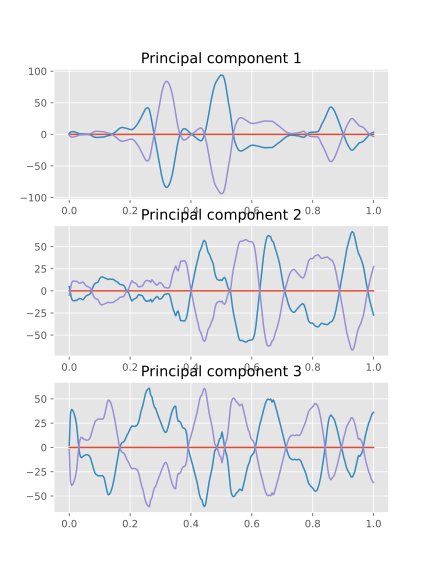

In [117]:
FPCAPlot(
    waves_fd.mean(),
    fpca_discretized.components_,
    factor=30,
    fig=plt.figure(figsize=(6, 2 * 4)),
    n_rows=3,
)

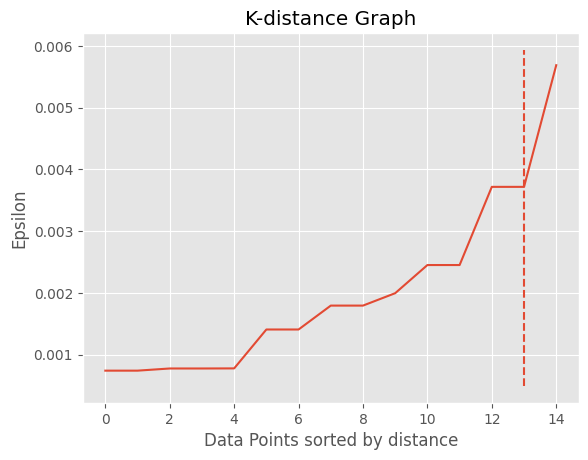

In [118]:
projection = fpca_discretized.transform(waves_fd)

# Get the projections of the first three components
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]
third_component_projection = projection[:, 2]

# Determine the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :3])
distances, indices = neighbors.kneighbors(projection[:, :3])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Use KneeLocator to find the elbow point
knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

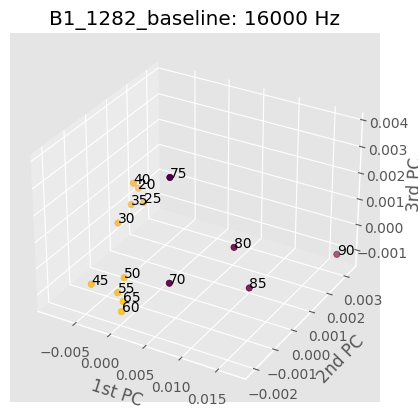

In [119]:
#Scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_component_projection, second_component_projection, third_component_projection)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :3])

# Color the points based on the cluster they belong to
ax.scatter(first_component_projection, second_component_projection, third_component_projection, c=clusters)

# Add labels
for i, db_value in enumerate(db_values):
    ax.text(first_component_projection[i], second_component_projection[i], third_component_projection[i], str(db_value))

plt.title(f'{filename}: {frequency} Hz')
ax.set_xlabel('1st PC')
ax.set_ylabel('2nd PC')
ax.set_zlabel('3rd PC')
plt.show()

In [120]:
import pandas as pd

# Create a DataFrame from the projection
df = pd.DataFrame(projection[:, :3], columns=['1st_PC', '2nd_PC', '3rd_PC'])

# Add the cluster assignments to the DataFrame
df['Cluster'] = clusters
# Add the db_values to the DataFrame
df['DB_Value'] = db_values

# Display the DataFrame
print(df)



      1st_PC    2nd_PC    3rd_PC  Cluster  DB_Value
0  -0.008602  0.001868  0.000447        0        20
1  -0.008322  0.002035 -0.000220        0        25
2  -0.007382  0.000415  0.000093        0        30
3  -0.007527  0.001135  0.000346        0        35
4  -0.007488  0.001248  0.001115        0        40
5  -0.005495 -0.001539 -0.000831        0        45
6  -0.003812 -0.000514 -0.001149        0        50
7  -0.002231 -0.001354 -0.001018        0        55
8  -0.000322 -0.001816 -0.001265        0        60
9   0.000859 -0.002111 -0.000557        0        65
10  0.005943 -0.001617  0.000222       -1        70
11  0.005287 -0.001318  0.003870       -1        75
12  0.010108  0.000135  0.000731       -1        80
13  0.012082  0.000213 -0.000722       -1        85
14  0.016900  0.003219 -0.001062       -1        90


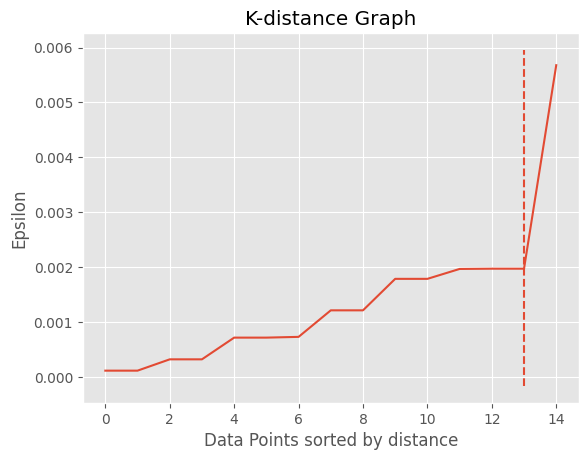

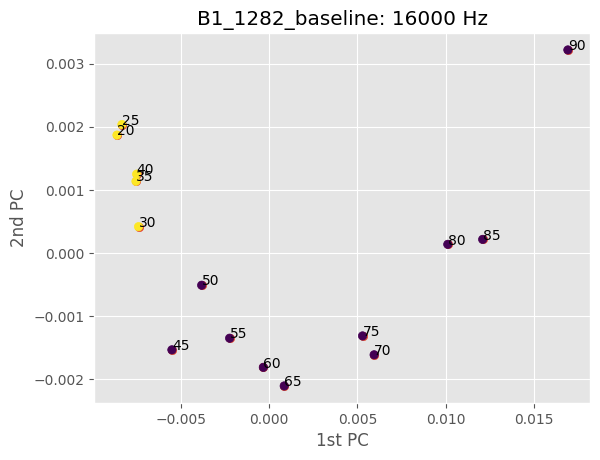

      1st_PC    2nd_PC  Cluster  DB_Value
0  -0.008602  0.001868        0        20
1  -0.008322  0.002035        0        25
2  -0.007382  0.000415        0        30
3  -0.007527  0.001135        0        35
4  -0.007488  0.001248        0        40
5  -0.005495 -0.001539       -1        45
6  -0.003812 -0.000514       -1        50
7  -0.002231 -0.001354       -1        55
8  -0.000322 -0.001816       -1        60
9   0.000859 -0.002111       -1        65
10  0.005943 -0.001617       -1        70
11  0.005287 -0.001318       -1        75
12  0.010108  0.000135       -1        80
13  0.012082  0.000213       -1        85
14  0.016900  0.003219       -1        90


In [121]:
# Importing necessary libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
import pandas as pd

# Transforming the data
projection = fpca_discretized.transform(waves_fd)

# Extracting the first two components of the projection
first_component_projection = projection[:, 0]
second_component_projection = projection[:, 1]

# Determining the optimal eps using K-distance Graph
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(projection[:, :2])
distances, indices = neighbors.kneighbors(projection[:, :2])
distances = np.sort(distances, axis=0)
distances = distances[:,1]

knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps = distances[knee_locator.knee]

# Plotting the K-distance Graph
plt.figure()
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.vlines(knee_locator.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

# Creating a 2D scatter plot
plt.figure()
plt.scatter(first_component_projection, second_component_projection)

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=eps)
clusters = dbscan.fit_predict(projection[:, :2])

# Coloring the points based on the cluster they belong to
plt.scatter(first_component_projection, second_component_projection, c=clusters)

# Adding labels to the points
for i, db_value in enumerate(db_values):
    plt.text(first_component_projection[i], second_component_projection[i], str(db_value))

# Finalizing the plot
plt.title(f'{filename}: {frequency} Hz')
plt.xlabel('1st PC')
plt.ylabel('2nd PC')
plt.show()

# Creating a DataFrame with each point and its corresponding cluster
df = pd.DataFrame(projection[:, :2], columns=['1st_PC', '2nd_PC'])
df['Cluster'] = clusters
df['DB_Value'] = db_values
print(df)
